###Sod's Shock Tube: Reconfigurable, Two-Chamber, Shock Tube Analysis
#####Nicholas Batista  ---  11/10/2015

In [ ]:
#Configurable Variables, as defined below:
#gamma
#dt & t_f
#nx, x_L, & x_R
#rel_membrane
#rho_L0 & rho_R0
#u_L0 & u_R0
#p_L0 & p_R0

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

ImportError: No module named JSAnimation.IPython_display

In [2]:
##########################
#####Test Definitions#####
##########################
#what? when?

gamma=1.4  #adiabatic index for air model (based on ratio of specific heats)
dt=0.0002  #time step length (s)
t_f=0.01   #time duration (s), Calculation of p, rho, & v in shock tube at t=t_f
nt=np.int(t_f/dt)

In [3]:
##########################
#####Build Tube Space#####
##########################
#where?

nx=81      #total number of indices
x_L=-10.0  #coordinate of left side of tube (m), high pressure side
x_R=10.0   #coordinate of right side of tube (m), low pressure side

x=np.linspace(x_L,x_R,nx)


In [4]:
########################
#####Build Membrane#####
########################
#how?

rel_membrane=0.5   #position of membrane relative to left side, normalized by total length

chk=np.zeros_like(x)
for i in range(nx):
    chk[i]=round(x[i],4)
dx=(x_R-x_L)/np.float(nx-1)            #spacial step length (m),0.25
x_membrane=x_L+dx*np.round(nx*rel_membrane)
x_membrane=round(x_membrane,4)

indices=[i for i,j in enumerate(chk) if j>x_membrane]
x_indx_membrane=indices[0]-1

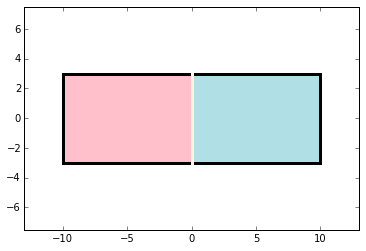

In [5]:
#######################################
#####Visualize Shock_Tube Geometry#####
#######################################

#Assume tube is large enough to ingore viscous effects at walls
#i.e., in cartesian coordinate system, where x-axis is along the length of the tube,
#distributions of pressure, velocity, and density are uniform at each x-coordinate for all y- & z- coordinates
pic=0.15*np.abs(x_R-x_L)
b_L=x_L-pic
b_R=x_R+pic

tube=plt.plot((x_L,x_L),(-pic,pic),'k-',(x_L,x_R),(pic,pic),'k-',(x_R,x_R),(-pic,pic),'k-',(x_R,x_L),(-pic,-pic),'k-',(x_membrane,x_membrane),(-pic,pic),'#FDF5E6')
plt.xlim(b_L,b_R)
plt.ylim(-pic*(2.5),pic*(2.5))
plt.setp(tube,linewidth=3.0)
plt.fill_between((x_L,x_membrane),-pic,pic,facecolor='pink')
plt.fill_between((x_membrane,x_R),-pic,pic,facecolor='#B0E0E6')

In [6]:
###########################################################################
#####Define Initial Tube Conditions on Left and Right Side of Membrane#####
###########################################################################
rho_L0=1.0       #(kg/m^3), initial density, left side
u_L0=0.0         #(m/s), initial air velocity, left side
p_L0=100000.0    #(N/m^2), initial pressure, left side
rho_R0=0.125     #(kg/m^3), initial density, right side
u_R0=0.0         #(m/s), initial air velocity, right side
p_R0=10000.0     #(N/m^2), initial pressure, right side

#Conserved Variables, based on Euler's equations
#p_0=(gamma-1)*rho_0*e_T
#rho_0*e_T=p_0/(gamma-1)
def u_initial(nx_inp):
    """
    Input:
    nx_inp-shape of tube space vector (pre-defined as nx)
    """
    u=np.zeros((3,nx_inp))
    
    for i in range(nx_inp):
        if i<x_indx_membrane:
            u[0,i]=rho_L0
            u[1,i]=rho_L0*u_L0
            u[2,i]=p_L0/(gamma-1.0)
        else:
            u[0,i]=rho_R0
            u[1,i]=rho_R0*u_R0
            u[2,i]=p_R0/(gamma-1.0)
    return u
#Flux Vector, in terms of conserved variables
def F_calc(u_in):
    """
    Input:
    u_in=output of u_initial()
    """
    #Initialize
    Fcalc=np.zeros_like(u_in)
    #Populate
    Fcalc[0,:]=u_in[1,:]
    Fcalc[1,:]=((u_in[1,:]**2)/u_in[0,:]) + (gamma-1)*(u_in[2,:]-0.5*(u_in[1,:]**2)/u_in[0,:])
    Fcalc[2,:]=(u_in[2,:]+(gamma-1)*(u_in[2,:]-0.5*(u_in[1,:]**2)/u_in[0,:]))*(u_in[1,:]/u_in[0,:])
    return Fcalc

In [7]:
def richtmyer(u_initial,d_t,n_t,d_x,n_x):
    """
    Input:
    u_initial=u_0
    d_t=dt
    n_t=nt
    d_x=dx
    n_x=nx
    """  
    #Initialize
    un=np.zeros((n_t+1,3,n_x))
    ustar=np.zeros((3,n_x))
    U=np.zeros((3,n_x))
    #Populate
    un[:,:,:]=u_initial[:,:]
    ustar[:,:]=u_initial[:,:]
    U[:,:]=u_initial[:,:]
    #"Richtmyer is a Two-Step Method"
    for j in range(1,nt+1):
        #Predictor
        Fstar=F_calc(U)
        ustar[:,:-1]=0.5*(U[:,1:]+U[:,:-1])-(d_t/(2*d_x))*(Fstar[:,1:]-Fstar[:,:-1])
        #Corrector
        F=F_calc(ustar) 
        un[j,:,1:-1]=U[:,1:-1]-(d_t/d_x)*(F[:,1:-1]-F[:,:-2])
        U=un[j,:,:].copy()
    return un[:,:,:]

In [8]:
############################
#####Execute Simulation#####
############################
u_0=u_initial(nx)
un_f=richtmyer(u_0,dt,nt,dx,nx)

In [9]:
##############################
#####Visualize Simulation#####
##############################

#def animate(data):
#    x=numpy.linspace(0,4,nx)
#    y=data
#    line.set_data(x,y)
#    return line,
#u=u_initial()
#sigma=1
#dt=sigma*dx

#un=maccormack(u,nt,dt,dx)

#fig=plt.figure();
#ax=plt.axes(xlim=(0,4),ylim=(-0.5,2));
#line,=ax.plot([],[],lw=2);

#anim=animation.FuncAnimation(fig,animate,frames=un,interval=50)
#display_animation(anim,default_mode='once')

In [10]:
############################
#####Simulation Results#####
############################
#why?
v_f=un_f[nt,1,50]/un_f[nt,0,50]
p_f=(gamma-1)*(un_f[nt,2,50]-0.5*(un_f[nt,1,50]**2)/un_f[nt,0,50])
rho_f=un_f[nt,0,50]

In [11]:
v_f

292.61147152682651

In [12]:
p_f

30250.89016757203

In [13]:
rho_f

0.3746914026476012

In [ ]:
#calculate relative density compared to initial